<font color='red'> As we will use neural networks (NNs) on images today, make sure to use a gpu to run this notebook (on colab : Execution -> Modifier le type d'Execution -> GPU) </font>

# Install the OTT package, import the appropriate librairies, check you are using a GPU

In [ ]:
#!pip install ott-jax==0.3.1

Load the usual packages and those related to jax and ott

In [ ]:
import numpy as np
import os
from typing import Any, Callable, Sequence, Tuple
from typing import Iterator, Optional
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision
import torch

import jax
import jax.numpy as jnp
import jax.random as random
from functools import partial
from jax import jit
import optax
from optax._src import base
import flax.linen as nn
from flax.training import train_state

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence


PRNGKey = Any
Shape = Tuple[int]
Dtype = Any
Array = Any

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


If you are using the colab GPU, the following cell should print "gpu". If not, you can run this notebook on a CPU but it will be a bit slower.

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [ ]:
# Plotting functions
def just_plot(sample, color = "violet", label="", figsize=(5, 5)):
    x_sample = np.array(sample[:,0])
    y_sample = np.array(sample[:,1])
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.scatter(x_sample, y_sample,  s=10, color=color, label=label)
    plt.legend()
    plt.show()

def draw(source_sample, target_sample, state):
    ot_map_point = jax.grad(state.apply_fn, argnums=1)
    ot_map = jax.vmap(lambda x: ot_map_point({'params': state.params}, x))
    predicted = ot_map(source_sample)
    x_pred = np.array(predicted[:,0])
    y_pred = np.array(predicted[:,1])
    x_target = np.array(target_sample[:,0])
    y_target = np.array(target_sample[:,1])
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    ax.scatter(x_target, y_target,  s=10, color='pink', label="target")
    ax.scatter(x_pred, y_pred, s=10, label="predicted")
    plt.legend()
    plt.show()

def plot_dataset(sample, offset = 0):
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = sample[offset+i].reshape(16,16)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

def plot_differences(source, target, state, offset=0):
    ot_map_point = jax.grad(state.apply_fn, argnums=1)
    ot_map = jax.vmap(lambda x: ot_map_point({'params': state.params}, x))
    predicted = ot_map(source)
    fig = plt.figure(figsize=(15, 6))
    columns = 5
    rows = 2
    for i in range(1, columns*rows +1):
        if i < 6 :
          img = source[offset+i].reshape(16,16)
        else :
          img = predicted[offset+i-5].reshape(16,16)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

# Reminders about Optimal Transport theory and Objectives of this session

$\newcommand{\cali}{\mathcal}$
$\newcommand{\inc}{\subset}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathbb{N}}$


**Pushforward operator**
We consider the euclidean space $(\R^d,\|.\|)$ and denote by $\cali{P}(\R^d)$ the set of Borel probability measures on $\R^d$.
Given a probability measure $\mu \in \cali{P}(\R^d)$ and a map $T: \R^d \longrightarrow \R^d$, the pushforward operator allows to construct another measure $T_{\#} \mu  \in \cali{P}(\R^d)$ defined as:
$$
    \forall A \inc \R^d, \quad T_{\#}\mu(A) = \mu(T^{-1}(A))
$$
where $T^{-1}(A) = \{ x\in \R^d: T(x) \in A\}$. One says that $T$ transports $\mu$ on $\nu$ when the constructed measure $T_{\#} \mu$ is precisely the measure $\nu$, ie $T_{\#} \mu = \nu$.


**Monge problem and Kantorovich problem**
Prior to the Kantorovich problem, the Monge optimal transport problem seeks a map $T : \R^d \longrightarrow \R^d$ that transports $\mu$ on $\nu$ while minimizing the transport cost:
$$
    \cali{M}_p(\mu,\nu)^p = \min_T \left\{ \int_{\R^d} \|x-T(x)\|^p \text{d}\mu(x) : T_{\#}\mu = \nu \right\}
$$
for a certain $p\in \N^*$.
 A first difficulty introduced by this fomulation of distance is that an optimal maps $T$ to this problem, also called Monge map, might not exist. An other obstacle raised by the Monge problem is that the constraint ($T_{\#}\mu = \nu$) and the functional are non-convex. To circumvent these difficulties, the Kantorovich problem which is a relaxed version of the Monge problem has been proposed:
$$
    W_p(\mu,\nu)^p = \min_{\pi \in \cali{U}(\mu,\nu)} \int_{\R^d\times\R^d} \|x-y\|^p \text{d}\pi(x,y)
$$
where $\cali{U}(\mu,\nu)$ is the set of probability distribution on $\R^d\times \R^d$ with marginals $\mu$ and $\nu$ define as,

$$
    \cali{U}(\mu,\nu)= \left \{\pi \in \cali{P} \left (\R^d\times\R^d \right ), P_1{}_{\#}\pi = \mu, P_2{}_{\#}\pi = \nu \right \}
$$
with $P_1(x,y) = x$ and $P_2(x,y) = y$. The Kantorovich problem is an inifinite-dimensional linear program over the space of measures $\cali{U}(\mu,\nu)$ which always has solutions. Its optimal value $W_p(\mu,\nu)^p$ defines a notion of distance between probability distributions and is referred as the Wasserstein-p distance.

<font color='black'> During the last session, we solved the Kantorovich problem in the discrete setting ie when $\mu$ and $\nu$ are supported on a finite set of points and we were interested in the value of these optimization problems. The objective was then to measure how close two distributions $\mu$ and $\nu$ were using the quantity $W_p(\mu,\nu)^p$ which is a practical notion of distance between distributions. Note that we also defined and compute the entropic regularisation of Kantorovich problem using the Sinkhorn algorithm which is a very fast algorithm that allows to estimate $W_p(\mu,\nu)^p$. If this notion of distance between distributions is one of the main applications of the OT problem, sometimes we are also interested in computing the transport plan $\pi^*$ (when solving Kantorovich problem) or the map $T^*$ (when solving Monge problem) that give the optimal value of the problem. In this session, we will see two different ways to approximate the OT map $T^*$ and see how computing this $T^*$ permits to solve the Domain Adaptation problem. </font>

## Setting

We have access to samples from $\mu$ and $\nu$ that are unknown probability distributions and we would like to estimate the OT map $T^*$ from $\mu$ to $\nu$ using these samples. Let us denote $(X_1, ..., X_n)$ and $(Y_1, ..., Y_n)$ the samples from $\mu$ and $\nu$ respectively and $\hat{\mu}_n$, $\hat{\nu}_n$ the empirical distributions associated to these samples. **During this session, we will see two different ways to approximate $T^*$. The first way consists in using the Entropic map and the second way is a deep learning method.**

# The Entropic map

A first way to approximate $T^*$ is to use the Entropic map which was defined during the OT course. This map is built from the OT plan associated to the entropic regularized problem between $\hat{\mu}_n$ and $\hat{\nu}_n$. Let us denote $g$ and $f$ the dual potentials returned by Sinkhorn algorithm. The entropic map is then defined as follows :

$$T_{\epsilon, n}(x) = \frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\epsilon} \left(g_i - \frac{1}{2} \|x - Y_i\|^2 \right)}}{\frac{1}{n} \sum_{k=1}^n e^{\frac{1}{\epsilon} \left(g_k - \frac{1}{2} \|x - Y_k\|^2 \right)}}$$

The entropic map $T_{\epsilon, n}$ allows to transport a new point $x \sim \mu$ on the $\nu$ distribution. Let us see how to implement it for specific distributions $\mu$ and $\nu$ and samples from them.

Let $\mu$ be the uniform distribution on the euclidean ball and $\nu$ the banana shaped distribution. The following cells create samplers from these distributions.

***
**Question:**
* Complete the following the code where there is a ``...``

In [ ]:
def unit_ball_sampler(key, n_dim):
  """Sample a point uniformaly in a n_dim dimension unit ball

  Hint: Use the following quote:

      If Y is drawn from the uncorrelated multivariate normal distribution,
      then S = Y / ||Y|| has the uniform distribution on the unit d-sphere.
      Multiplying S by U^1/d, where U has the uniform distribution on the unit
      interval (0,1), creates the uniform distribution in the unit d-dimensional ball.
  """

  ...

In [ ]:
def banana_sampler(key):
  """Sample a point from a banana shape distribution

  """

  key_x, key_phi, key_z = jax.random.split(key, num=3)
  x = jax.random.uniform(key_x) * 2 - 1
  phi = jax.random.uniform(key_phi) * 2 * jnp.pi
  z = jax.random.uniform(key_z)
  r = 0.2 * z * (1 + (1 - jnp.abs(x)) / 2)

  return jnp.array([ x + r * jnp.cos(phi), x**2 + r * jnp.sin(phi)])

In [ ]:
class Unit_ball_sampler:
    def __init__(self , dim: int=2):
        self.dim = dim
        self.setup()

    def setup(self):
        """
        Create a unit ball sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.

                Hint: Use the unit ball sampler and vmap
            """

            ...

            return points

        self.generate_samples = generate_samples

In [ ]:
class Banana_shaped_sampler:
    def __init__(self ):
        self.setup()

    def setup(self):
        """
        Create a banana shaped sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.

                Hint: Use the banana sampler and vmap
            """

            ...

            return points

        self.generate_samples = generate_samples

Let us initiate the two samplers and draw samples from them (n=1024)

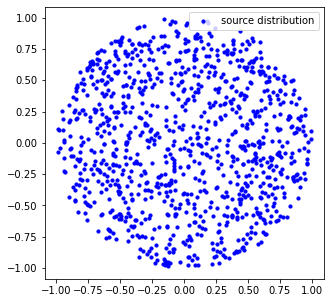

In [ ]:
n=1024
rng = jax.random.PRNGKey(0)
# initiate sampler
source_sampler = Unit_ball_sampler()
# draw 1024 iid samples from it  (try removing the @partial(jit...))
X = source_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(X, label="source distribution", color="blue")

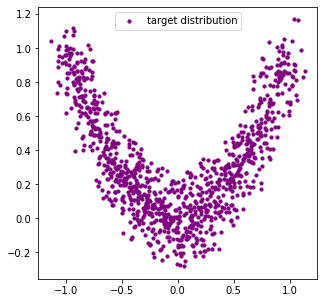

In [ ]:
# initiate sampler
target_sampler = Banana_shaped_sampler()
# draw 1024 iid samples from it
Y = target_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(Y, label="target distribution", color="purple")

Now that we have X and Y that are samples drawn from $\mu$ and $\nu$ respectively, you need to run sinkhorn algorithm in order to get the associated potentials $f$ and $g$ and be able to construct the entropic map as defined above. To do that, you can take your own sinkhorn of last time and use $f = \log(u)$ and $g=\log(v)$ or use the OTT solver and get back the potentials associated to the solution like done below. Check the definition of Sinkhorn algorithm if the definition of $f,g,u,v$ is not clear for you.

In [ ]:
epsilon=0.1
n = len(X)

geom = ott.geometry.pointcloud.PointCloud(X, Y)                   # Define an euclidean geometry
problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

out = solver(problem)                                             # Solve it !

f = out.f                                                         # Get back the potentials f and g
g = out.g

Once the potentials $f$ and $g$ have been computed, you can define the entropic map as defined above.
***
**Question:**
* Complete this function that takes as input $x$ which is a point in $\R^2$ (and not a batch of points) and return $T_{\epsilon, n}(x) \in \R^2$

In [ ]:
def entropic_map_(x, g=g, Y=Y, epsilon=epsilon, n=n):
    """
    Compute the entropic map
    """

    ...

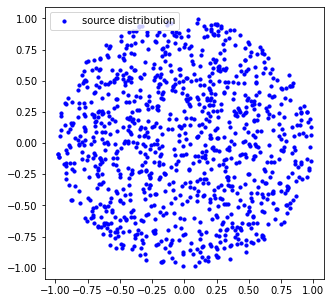

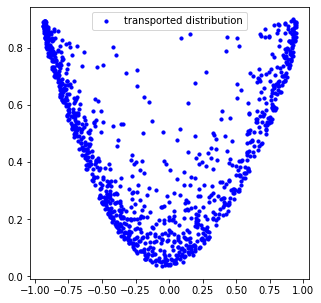

In [ ]:
# Use jax.vmap to define a function that takes a batch of samples as input.
entropic_map_batch = jax.vmap(entropic_map_, in_axes=0, out_axes=0)

# Draw new samples X' from the source distribution
rng, rng_2 = jax.random.split(rng, num=2)
X_p = source_sampler.generate_samples(rng_2, n)

# Transport the batch X' with that function
transported_samples = entropic_map_batch(X_p)

# Plot the init_samples and transported samples
just_plot(X_p, label="source distribution", color="blue")
just_plot(transported_samples, label="transported distribution", color="blue")

We have transported a new set of samples X' using the entropic map. One can observe that the transported samples look like the one drawn from the target distribution but that it is not perfect. This is because our implementation of the entropic map is not optimal. Let us use the ott implementation of the sinkhorn map and transport X' again.


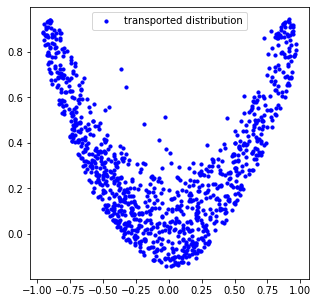

In [ ]:
# Define entropic map with the output of the solver
entropic_map = out.to_dual_potentials()

# Transport X with this map
transported_samples = entropic_map.transport(X_p)

# Plot the transported samples
just_plot(transported_samples, label="transported distribution", color="blue")

This time, the transported samples really look like those drawn from the banana distribution.

The entropic map is a first method to approximate the OT map $T^*$, we will now see another way to approximate $T^*$ using neural networks.

# Brenier's Theorem and ICNNs

An other way to estimate $T^*$ is to use Brenier's theorem to restrict the set of possible functions that can solve the OT problem.

### Brenier's Theorem

Brenier's theorem states sufficient conditions to ensure that the Monge problem has a unique solution and gives the form of the OT map $T^*$.

This theorem can be stated as follows:



**Brenier's Theorem**
In the Euclidean case $p=2$, if one of the two input measures ($\mu$ or $\nu$) has a density with respect to Lebesgue measure, then the Monge problem $\cali{M}_p(\mu,\nu)^p$ has a unique solution which is the gradient of a function $\phi$ uniquely defined as the convex function such that $(\nabla \phi)_{\#}\mu = \nu$.



Brennier's theorem tells us that, for the euclidean cost, the solution $T^*$ is the unique function that is a gradient of a convex function and that maps $\mu$ on $\nu$. A solution to compute $T^*$ is to find the only convex function $\phi$ such that its gradient maps $\mu$ on $\nu$.
In the following, we will parameterize $\phi$ with a neural network that is convex in its input and optimize it so that its gradient maps $\mu$ on $\nu$ ie so that the transported distribution be close to the target distribution.

In the following part, Input convex neural networks (ICNNs) are defined. These are Neural Networks that parameterize convex functions.

### ICNNs

Input Convex Neural Networks provide universal approximators for convex functions and have been very recently used in the ML community to model optimal transport maps. ICNN are neural networks $\phi_{\theta}(x)$ whose architecture and parameters are constrained to ensure that their output is a convex function of the input $x$. The architecture of typical FICNN with $k$ layers is drawn below.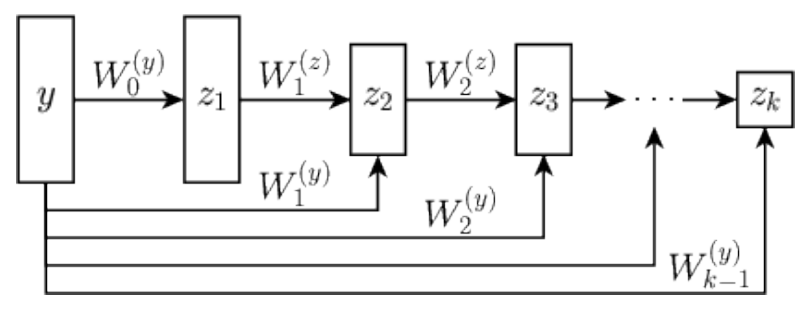


It is a fully connected network whose output can be expressed as:
$$z_{\ell+1} = a_\ell \left (W_{\ell}^{(z)}z_{\ell} + W_{\ell}^{(y)}y+b_{\ell} \right), \qquad \phi_{\theta}(y) = z_{\ell}$$
with $W_0^{(z)}=0$ and $\theta = \{W_{0:k-1}^{(y)}, W_{1:k-1}^{(z)}, b_{0:k-1}\} $. The activation functions $a_{\ell}$ are convex, non-decreasing non-linear and all $W_{1:k-1}^{(z)}$ are non-negative to ensure convexity.

With those constraints on the weights and on the activation functions, the neural network obtained parameterizes a convex function ie $\phi(θ) : \R^d ⟶ \R$ is convex.

We will now define this neural network using Flax which is one of the Deep Learning library that uses jax. **Please do the following tutorial : https://flax.readthedocs.io/en/latest/getting_started.html to learn the basics about doing deep learning with flax.**

In the definition of ICNNs, we saw that some weights must be non negative. For this reason, we cannot use nn.Dense layers but we have to customize them to ensure the weights remains non negative even when they are optimized. To do that, we will use a softplus function and construct PositiveDense layers that you can use as the nn.Dense layers.

In [ ]:
class PositiveDense(nn.Module):
    """A linear transformation using a non-negative matrice of weights"""
    dim_hidden: int
    beta: int = 30.0
    kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.lecun_normal()

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        kernel = self.param('kernel', self.kernel_init, (inputs.shape[-1], self.dim_hidden))
        kernel = 1/self.beta * nn.softplus( self.beta * kernel)
        x = jax.lax.dot_general(inputs, kernel, (((inputs.ndim - 1,), (0,)), ((), ())))
        return x


***
**Question:**
* Please complete the definition of the ICNN below.

In [ ]:

class ICNN(nn.Module):
  """ A fully connected input convex neural network """
  dim_hidden: Sequence[int]
  act_fn: Callable = ...
  init_fn: Callable = ...

  def setup(self):
    self.dim = ...
    self.w_zs = ...
    self.w_ys = ...

  @nn.compact
  def __call__(self, input):

    ...

    return ...

Once our NN defined, we can now train it so that its gradient $T_{\theta} = \nabla \phi_{\theta} : \R^d ⟶ \R^d$ transports $\mu$ on $\nu$. To do so, we can use the samples from $\mu$ : $X_1,...,X_n$ and the samples from $\nu$ : $Y_1, ..., Y_n$ and minimize a certain divergence $D$ between the point clouds $T_{\theta}(X_1),..., T_{\theta}(X_n)$ and $Y_1, ..., Y_n$. When done, $T_{\theta}$ transports $\hat{\mu}_n$ on $\hat{\nu}_n$ and we can expect that if $n$ is large enough, $T_{\theta}$ would approximately transports $\mu$ on $\nu$. The divergence $D$ we use in practice (and that we will use in this notebook) is the sinkhorn divergence.

## Train the ICNN

***

**Question:** Complete the training of the ICNN, in particular use the sinkhorn divergence loss of ott jax.

In [ ]:
class OT_Solver:
    """Compute OT map"""

    def __init__(self,
                 input_dim: int,
                 neural_net: Optional[nn.Module] = None,
                 optimizer: Optional[base.GradientTransformation] = None,
                 num_train_iters: int = 20000,
                 plot_function = None,
                 seed: int = 0):

        self.num_train_iters = num_train_iters
        self.plot_function = plot_function

        # set random key
        rng = jax.random.PRNGKey(seed)
        rng, rng_setup = jax.random.split(rng,2)
        self.key = rng

        # set default optimizer
        if optimizer is None:
            optimizer = optax.adam(learning_rate=0.001)

        # set default neural architecture
        if neural_net is None:
            neural_net = ICNN(dim_hidden=[64, 64, 64])

        self.setup(rng_setup, neural_net, input_dim, optimizer)


    def setup(self, rng, neural_net, input_dim, optimizer):
        """Setup all components for training"""
        rng, rn_state = jax.random.split(rng,2)
        self.state = self.create_train_state(rn_state, neural_net, optimizer, input_dim) # contains model, parameters and optimizer
        self.train_step = self.get_step_fn()


    def __call__(self,
                 sampler_source: Iterator[jnp.ndarray],
                 sampler_target: Iterator[jnp.ndarray],
                 size_batch_train):
        _ = self.train_quantile_net(sampler_source, sampler_target, size_batch_train)
        return self.state

    def train_quantile_net(self,sampler_source, sampler_target, size_batch_train):
        batch = {}
        master_key = self.key
        for step in range(self.num_train_iters):
            # generate new batch
            master_key, inner_key_source, inner_key_target = jax.random.split(master_key, num=3)
            batch['source'] = sampler_source.generate_samples(inner_key_source, size_batch_train)
            batch['target'] = sampler_target.generate_samples(inner_key_target, size_batch_train)

            # compute the loss function and apply a gradient step
            self.state, loss = self.train_step(self.state, batch)

            if step % 100 == 0:
                print('loss After {} Iterations : {:.6f}'.format(step, loss))

            # plot some figures
            if step % 1000 == 0 and self.plot_function:
                master_key, inner_key_source, inner_key_target = jax.random.split(master_key, num=3)
                X_train = sampler_source.generate_samples(inner_key_source,size_batch_train)
                Y_train = sampler_target.generate_samples(inner_key_target,size_batch_train)
                self.plot_function(X_train, Y_train, self.state)
        return None

    def create_train_state(self, rng, neural_net, optimizer, input_dim):
        params = neural_net.init(rng, jnp.ones(input_dim))['params']
        return train_state.TrainState.create(apply_fn=neural_net.apply, params=params, tx=optimizer)

    def get_step_fn(self):
        def loss_fn(params, predict, batch):
            """This is the loss function it should return a number

            Hint: it should follow those steps:
              - compute the gradient of the ICNN with respect to the input to get the ot map
              - use vmap so that ot_map take as input batch of samples
              - transport the source samples
              - Minimize the distance between the transported samples and the target samples
                using sinkhorn_divergence
            """

            ...

            loss = ...

            return loss

        @jax.jit
        def step_fn(state, batch):
            value_and_grad_fn = jax.value_and_grad(loss_fn)
            loss, grad = value_and_grad_fn(state.params, state.apply_fn, batch)
            return state.apply_gradients(grads=grad), loss
        return step_fn

Let us train our ICNN to transport the source distribution on the target distribution.

loss After 0 Iterations : 8.424418


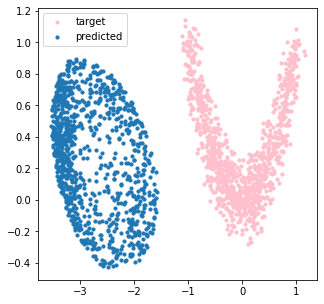

loss After 100 Iterations : 0.075100
loss After 200 Iterations : 0.054740
loss After 300 Iterations : 0.045731
loss After 400 Iterations : 0.043082
loss After 500 Iterations : 0.035202


KeyboardInterrupt: ignored

In [ ]:
# Let's train the ICNN

# Define the architecture and the optimizer
icnn = ICNN(dim_hidden=[64,64,64])
optimizer = optax.adam(learning_rate=1e-3)

# Set the number of steps
num_train_iters = 4000

# Setup the solver
solver = OT_Solver(
    input_dim=input_dim,
    neural_net=icnn,
    optimizer=optimizer,
    num_train_iters=num_train_iters,
    plot_function=draw
)

# Launch the train !
OT_state = solver(
    sampler_source=source_sampler,
    sampler_target=target_sampler,
    size_batch_train=1024
)

Now that our NN has been train, we can transport the batch of samples $X_p$ drawn from the source distribution. The parameters of the NN are contained in the variable OT_stat returned by the training algorithm.

***
**Question:**
* Complete this following code

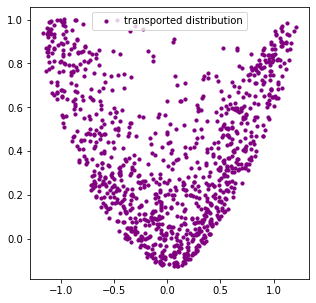

In [ ]:
# Let's see the final results

# Define the predict function
predict = ...
params = ...

# Extract the ot map from predict
ot_map_point = ...

# Use vmap to vectorize the ot_map
ot_map = ...

# Get the prediction
predicted = ...

# Plot the results
just_plot(predicted, label="transported distribution", color="purple")

The result got is quite good. Note that you can get better result with a larger network and a fancy training.

In the following, we will use this second method to approximate OT map to solve the Domain Adaptation problem.

# Domain Adaptation problem

In the unsupervised setting, the domain adaptation problem can be informally stated as follows:

You are given samples from a source distribution $\mu$ and those samples are labelled. You are also given samples from atarget distribution $\nu$ but those samples are unlabelled. The objective is to learn the labels of this target distribution using those of the source.

The domain adaptation problem has been originally formalized to compensate the
existing shift between training and test data that prevents ML algorithm to behave well in real applications. The objective is then to artificially align the training data on the test data before learning a ML algorithm on the training set. Then because the training and test data are now aligned, the algorithm learned on the training data is more likely to generalize well. To take a concrete example, let us look at the current datasets used in Domain Adaptation.
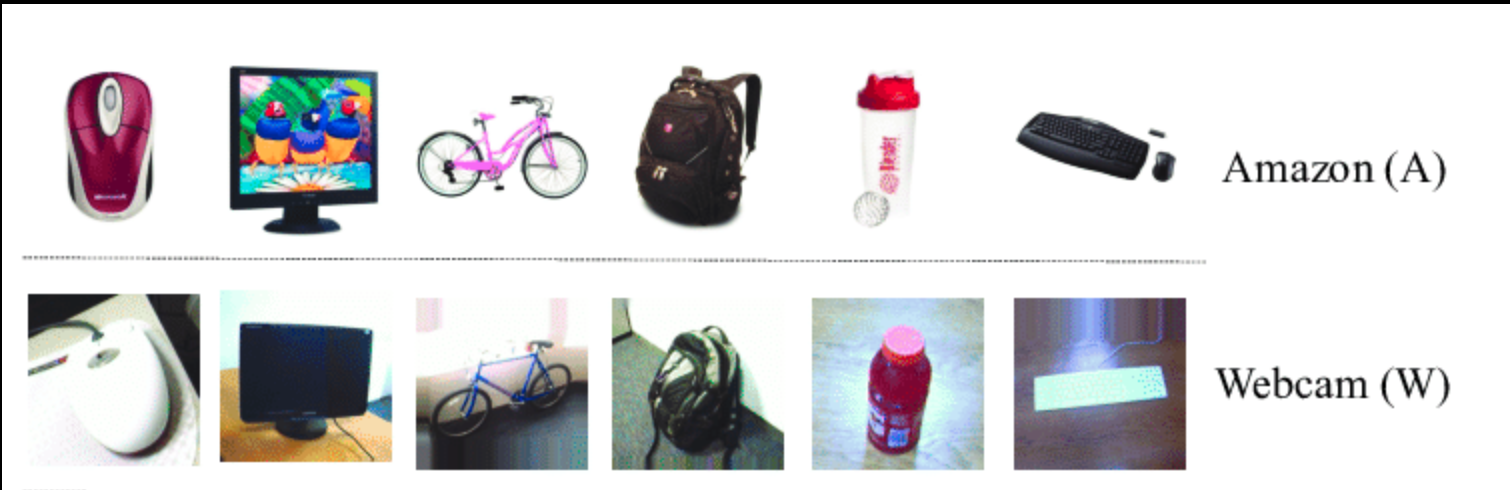

Let us imagine you know how to classify images from the Amazon dataset ie for an image without any background you can tell whether the object on the image is a bike or a bag or a TV and you would like to be able to classify images where the background is not removed like in the Webcam dataset. A solution to solve this problem is to transport the images of the Amazon dataset on the Webcam dataset with an OT map that will garantee that a back with no background will be transported on a bag with a background. Then, you can learn a classifier on the transported samples (as you know their labels) and apply it to the target distribution (images with background to labellize them) as explained on the following drawing.

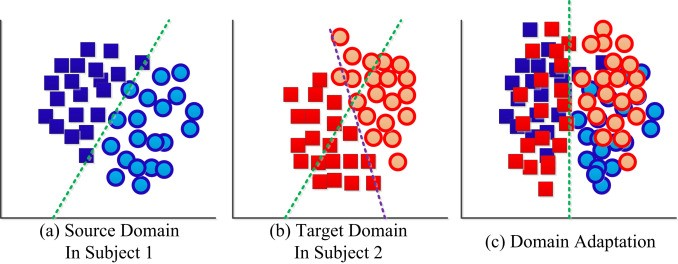

In the following, we will do this with less complex datasets and we will transport the MNIST dataset on the USPS dataset.

We first define a sampler that takes as input a dataset and allow to sample from this complete dataset like a dataloader would do.

In [ ]:
class sampler_from_data:
    def __init__(self, x ):
        self.x = x
        self.setup()

    def setup(self):
        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            points = jax.random.choice(key, self.x, (num_samples,))
            return points

        # define samples generator
        self.generate_samples = generate_samples

Let us download the training data from the MNIST dataset.

### MNIST Dataset

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)
mnist_data = mnist_trainset.data
mnist_labels = jnp.array(mnist_trainset.targets)
print(mnist_data.shape, mnist_labels.shape)

We resize the images of MNIST so that their size match the size of the USPS images (ie 16 x 16) and then reshape them to transform an image of size 16 x 16 into a vector of size 256. We finally renormalize them between 0 and 1.

In [ ]:
transform = torchvision.transforms.Resize((16,16))
mnist_data_resize = np.array(transform(mnist_data))
mnist_data_final = jnp.array([elt.reshape(16*16).astype(float)/255.0 for elt in mnist_data_resize])
print(mnist_data_final.shape)


(60000, 256)


We can use the solver defined above to create batch of samples that we can visualize using the plot_dataset function.

***
**Question:**
* Complete this sampler

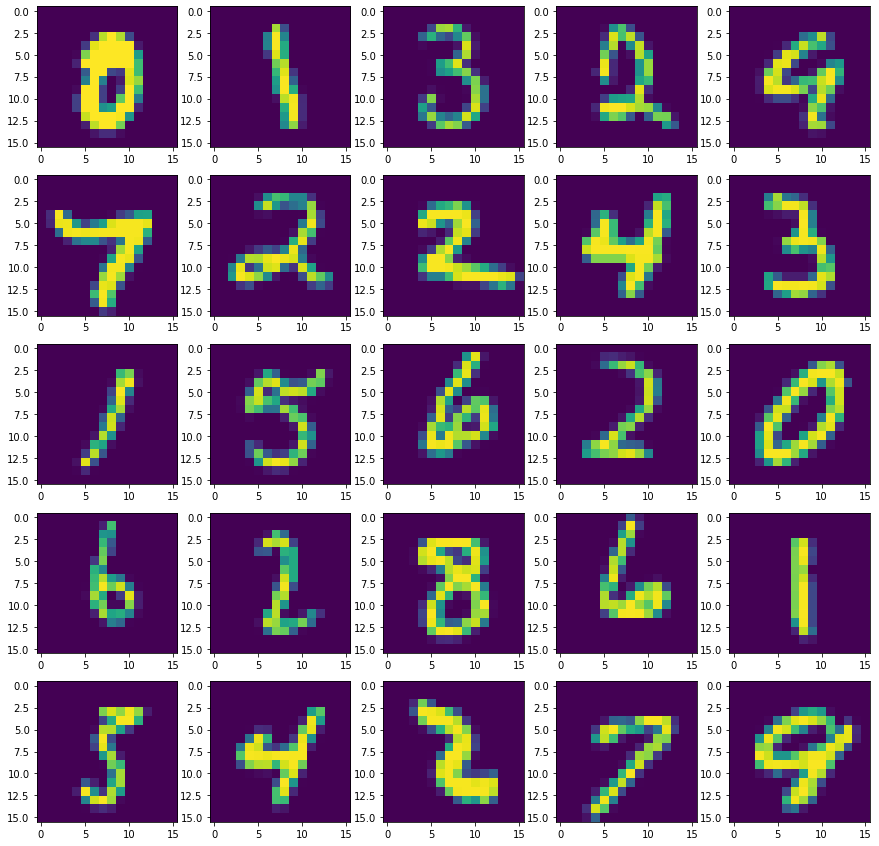

In [ ]:
# Create a mnist sampler
sampler_source_train = ...

# Sample 50 images
source_samples = ...

# Plot
plot_dataset(source_samples)

As we can see, the MNIST dataset are images of digits and their corresponding labels (ie an images of the digit five is associated to the label 5).

### USPS dataset

The same way, we load the USPS dataset which is also constituted of images of digits but drawn in a different way.

In [ ]:
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=None)

In [ ]:
usps_data = np.array(usps_trainset.data)
usps_labels = jnp.array(usps_trainset.targets)
usps_data_final = jnp.array([elt.reshape(16*16).astype(float)/255.0 for elt in usps_data])
print(usps_data_final.shape)


(7291, 16, 16) (7291,)
(7291, 256)


***
**Question:**
* Complete this sampler

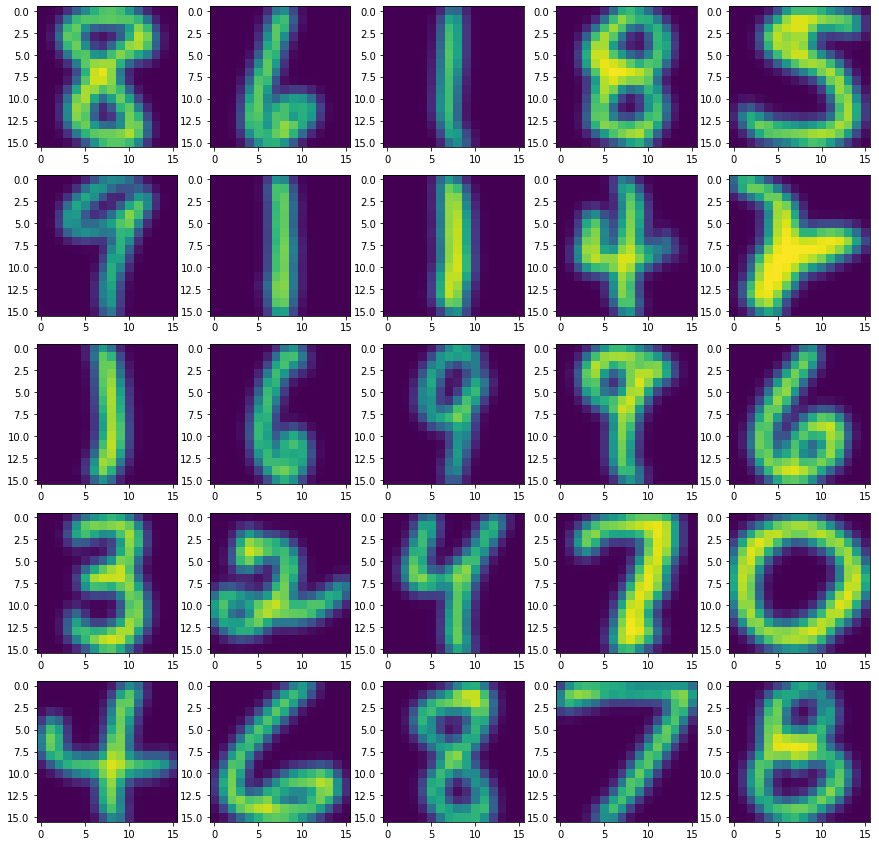

In [ ]:
# Create a usps sampler
sampler_target_train = ...

# Sample 50 images
target_samples = ...

# Plot
plot_dataset(target_samples)

**For the USPS dataset we will pretend that the labels are unknown and we need to learn them using the MNIST dataset which is labelled.**
To this end, we will transport the MNIST training data on the USPS training data using an ICNN.

***
**Question:**
* Based on the previous training of ICNN try and create the code to train this new ICNN

loss After 0 Iterations : 77.230873


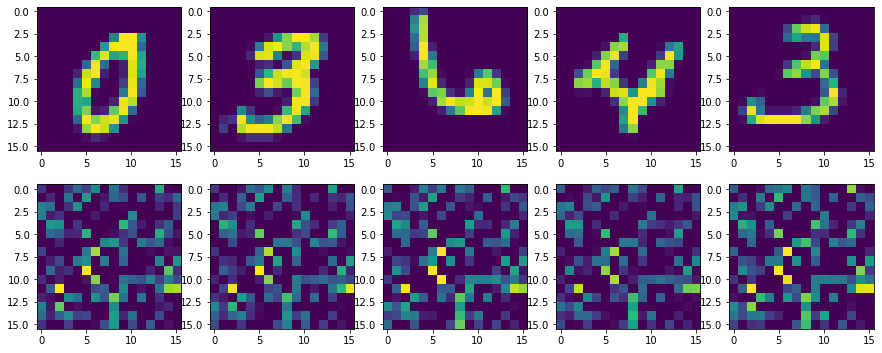

loss After 100 Iterations : 13.030775
loss After 200 Iterations : 10.125936
loss After 300 Iterations : 9.297516
loss After 400 Iterations : 8.368441
loss After 500 Iterations : 7.132897
loss After 600 Iterations : 6.708554
loss After 700 Iterations : 6.115862
loss After 800 Iterations : 5.692986
loss After 900 Iterations : 5.494826
loss After 1000 Iterations : 5.462949


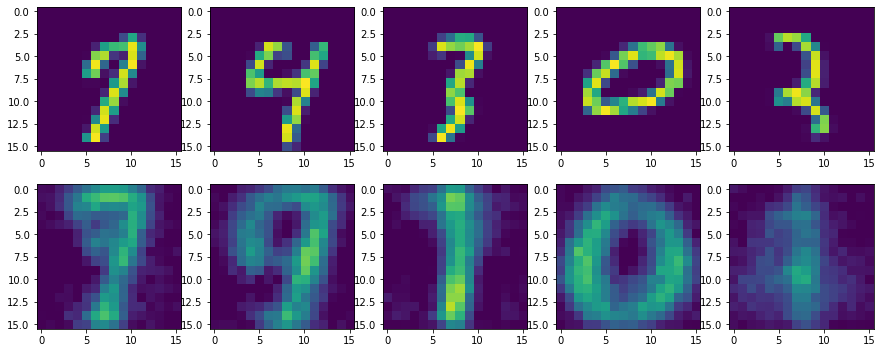

loss After 1100 Iterations : 5.283597
loss After 1200 Iterations : 5.223114
loss After 1300 Iterations : 5.034379
loss After 1400 Iterations : 5.099154
loss After 1500 Iterations : 5.123048
loss After 1600 Iterations : 4.852206
loss After 1700 Iterations : 5.110939
loss After 1800 Iterations : 5.044547
loss After 1900 Iterations : 4.794874
loss After 2000 Iterations : 4.884098


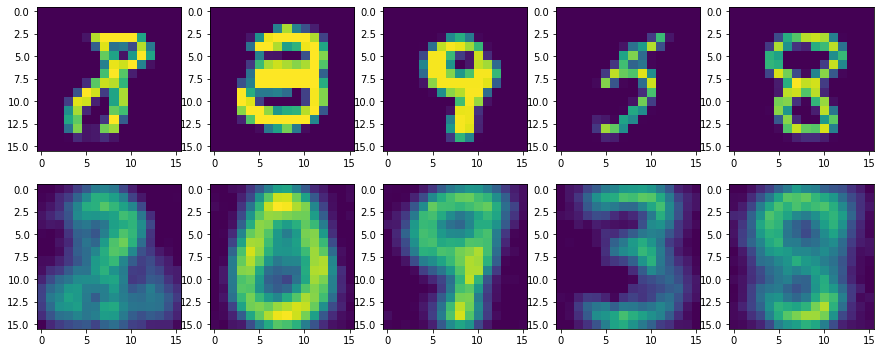

loss After 2100 Iterations : 4.615361
loss After 2200 Iterations : 4.716046
loss After 2300 Iterations : 4.807734
loss After 2400 Iterations : 4.739121
loss After 2500 Iterations : 4.673592
loss After 2600 Iterations : 4.712666
loss After 2700 Iterations : 4.679155
loss After 2800 Iterations : 4.594093
loss After 2900 Iterations : 4.618069
loss After 3000 Iterations : 4.605498


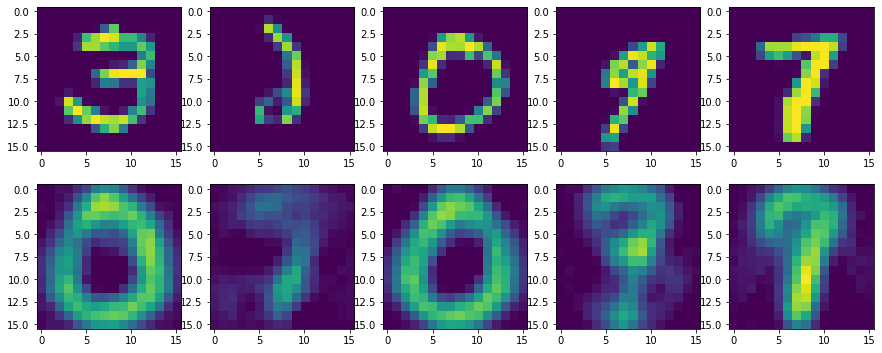

loss After 3100 Iterations : 4.615721
loss After 3200 Iterations : 4.578183
loss After 3300 Iterations : 4.372273
loss After 3400 Iterations : 4.544193
loss After 3500 Iterations : 4.493550
loss After 3600 Iterations : 4.487134
loss After 3700 Iterations : 4.561499
loss After 3800 Iterations : 4.504476
loss After 3900 Iterations : 4.510691


In [ ]:
"""
Hint:
 - The ICNN should have a hidden dimension of 64x64x64
 - We use adam optimizer with a learning rate of 1e-3
 - We train for 4000 steps

 WARNING: the plot function for the OT Solver need to be plot_differences
"""

...

OT_state = ...

We have trained our NN to transport the MNIST distribution on the USPS distribution, we can now learn a classifier on the transported samples and then use it on the USPS datasets to label USPS images. The easiest classifier is the 1 Nearest Neighboor classifier that consists to say that the USPS image we consider has the same label as the closest transported images from MNIST. We will use it in this notebook as it is parameter free and easy to use but note that usually we use SVM or NN.

We first transport the whole MNIST dataset and plot images of some of the transported samples.

***
**Question:**
* Try and complete the following

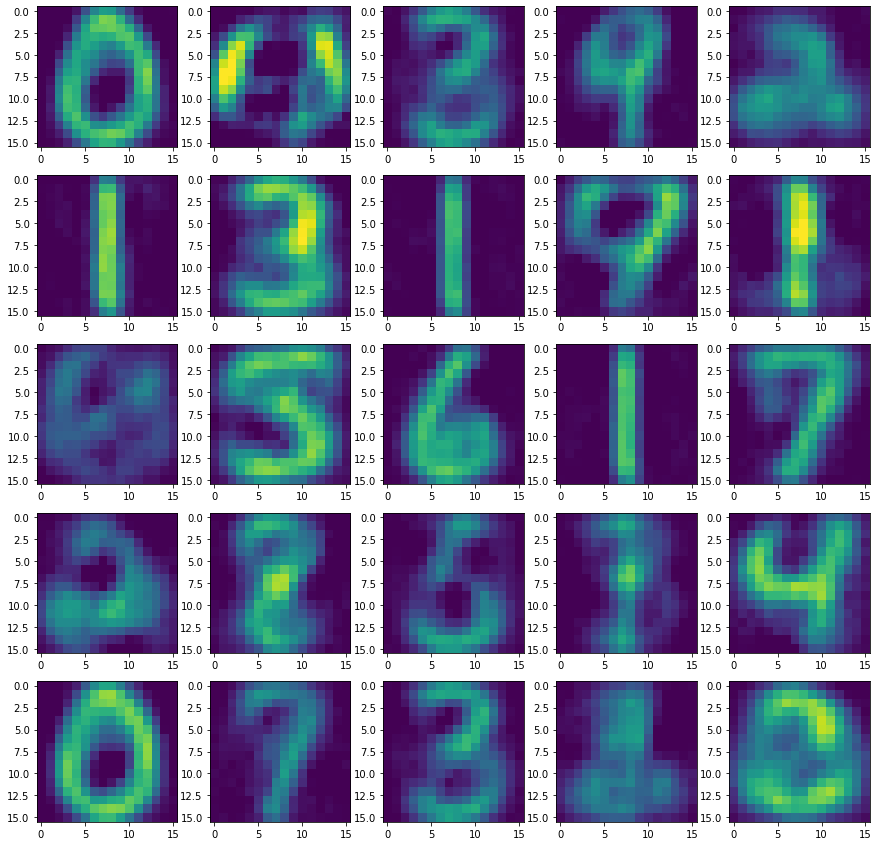

In [ ]:
# Let's see the final results

# Define the predict function
predict = ...
params = ...

# Extract the ot map from predict
ot_map_point = ...

# Use vmap to vectorize the ot_map
ot_map = ...

# Get the prediction
mnist_transported = ...

# Plot the results
plot_dataset(predicted)

The images look like the one of the USPS dataset. Let us now label the first 1000 images of the USPS dataset using the 1NN classifier and the first 1000 images of the MNIST images (to avoid memory errors).

***
**Question:**
* The goal of this question is to create a 1 nearest neighbour classifier. Try to complete the following.

In [ ]:
# Create a 1 nearest neighbour classifier using mnist labels

def dist_image2image(image1, image2):
    """This function return the distance between two images"""
    return ...

def NN1_label(target_img, transported_img, transported_labels):
    """This function takes a new image, find the nearest image from the
    transported_images and return its label.
    """

    # Calculate the distance between all transported images and or target
    dist_to_all_images = jax.vmap(
        lambda image: dist_image2image(target_img, image)
    )(transported_img)

    # Return the label of the nearest transported image
    return ...

# Vectorize the NN1_label
NN1_labels = ...

# Classify
guessed_labels = ...


Let us plot some USPS images with their labels that have been guessed using the 1NN classifier and the true label.

In [ ]:
plot_dataset(usps_data_final)
print("\nguessed labels:", guessed_labels[1:26])
print("\ntarget labels:", usps_labels[1:26])

We can compute the classification accuracy by comparing the label guessed using the 1NN classifier and the true label for the all USPS dataset.

In [ ]:
acc = jnp.mean(jnp.array(guessed_labels) == usps_labels[:1000])
print("1 NN Accuracy guessed vs target : ",acc)

The classification accuracy is around 60% which is not bad as we have 10 classes of digits. Note that we could do better using a larger NN whith a fancy training and with a SVM classifier (with the correct hyperparamter C) for eg.